In [1]:
# wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=14UBHX6GTW_4YiyjNJB3EEq7Xb83AjuaK' -O process_mining_datasets.zip

import pandas as pd
# pd.set_option("max_columns", 200)
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Meus pacotes
import parse_mxml as pm
import log_representation as lr
import plots as plts
import model_utils as mu
import drift_detection as dd
import offline_streaming_clustering as off_sc
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, ndcg_score, dcg_score, roc_curve, average_precision_score

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 
from scipy.optimize import linear_sum_assignment
import traceback 

from copy import deepcopy
import random
random.seed(42)
import os
import re
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial import distance
import glob

from sklearn.cluster import KMeans, AgglomerativeClustering

import gc
gc.enable()

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    https://stackoverflow.com/questions/50589770/ast-literal-eval-malformed-node-or-string-while-converting-a-string-with-list
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def opts_to_string(opts):
    return "_".join([
        opts["tipo_mudanca"] + str(opts["log_size"]/1000).replace(".0", "") + "k",
        str(opts["log_size"]),
        opts["model"],
        opts["representation"],
        str(opts["window_size"]),
        str(opts["sliding_window"])
    ])

# # # # # # # # # # #
# LOAN APPLICATIONS #
# # # # # # # # # # #
aliases = {
    'Loan__application_received': 'START',
    'Appraise_property': 'A',
    'Approve_application': 'B',
    'Assess_eligibility': 'C',
    'Assess_loan_risk': 'D',
    'Cancel_application': 'E',
    'Check__application__form_completeness': 'F',
    'Check_credit_history': 'G',
    'Check_if_home_insurance_quote_is_requested': 'H',
    'Prepare_acceptance_pack': 'I',
    'Receive_updated_application': 'J',
    'Reject_application': 'K',
    'Return_application_back_to_applicant': 'L',
    'Send_acceptance_pack': 'M',
    'Send_home_insurance_quote': 'N',
    'Verify_repayment_agreement': 'O',
    'Loan__application_approved': 'END_A',
    'Loan_application_rejected': 'END_R',
    'Loan__application_canceled': 'END_C',
}

inv_aliases = {v: k for k, v in aliases.items()}

objects = {
    "representation": {
        "binary": lambda x: lr.get_binary_representation(lr.get_traces_as_tokens(x)),
        "frequency": lambda x: lr.get_frequency_representation(lr.get_traces_as_tokens(x)),
        "tfidf": lambda x: lr.get_tfidf_representation(lr.get_traces_as_tokens(x)),
        "transitions": lambda x: lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)),
        "positions": lambda x: lr.get_positions_representation(lr.get_traces_as_tokens(x)),
        "positions_min_max": lambda x: lr.get_min_max_positions_representation(lr.get_traces_as_tokens(x)),
        "positions_avg": lambda x: lr.get_positions_representation(lr.get_traces_as_tokens(x), include_cols=["_avg"]),
    }
}

In [2]:
base_dir = "C:/Users/rafae/OneDrive/Documentos/resultados_clusterizacoes/"

In [3]:
def translateLabels(masterList, listToConvert):    
    contMatrix = contingency_matrix(masterList, listToConvert)
    labelMatcher = munkres.Munkres()
    labelTranlater = labelMatcher.compute(contMatrix.max() - contMatrix)

    uniqueLabels1 = list(set(masterList))
    uniqueLabels2 = list(set(listToConvert))

    tranlatorDict = {}
    for thisPair in labelTranlater:
        tranlatorDict[uniqueLabels2[thisPair[1]]] = uniqueLabels1[thisPair[0]]
    
    return tranlatorDict
    #return [tranlatorDict[label] for label in listToConvert]

In [4]:
from sklearn.metrics.cluster import contingency_matrix
import munkres

In [5]:
list1 = [1, 1, 0, 5, 5, 1, 8, 1]
list2 = [3, 3, 1, 2, 2, 3, 8, 3]

translateLabels(list2, list1)

{0: 8, 5: 1, 1: 2, 8: 3}

In [6]:
binary_support = ["cf", "cb", "cm", "rp", "pm", "fr"]
binary_not_support = ["pl", "cd", "cp", "sw"]
hardest = ["rp", "fr", "sw"]
easyest = ["cf", "cb", "cm", "pl", "cd", "cp", "sw"]
all_ = binary_support + binary_not_support

In [7]:
respostas = {
    'cb': ["I", "H"],
    'cd': ["D", "G"],
    'cf': ["M", "N"],
    'cm': ["I"], # descoberto 'na mão'
    'cp': ["D", "G"],
    # 'fr': ["A", "D", "G"],
    'fr': ['M', 'N'],
    'lp': ["A", "C", "D", "G"],
    'pl': ["A", "D", "G"],
    'pm': ["I"],
    're': ["C"],
    'rp': ["O", "Replaced_Activity"], # + Replaced Activity 
    'sw': ["O", "I", "H"],
    'IOR': ["K"], # + Added Activity
    'IRO': ["O", "I"], # + Added Activity
    'OIR': ["D", "G", "A"], # + Added Activity
    'ORI': ["H", "N", "M", "O"], # + Added Activity
    'RIO': ["N", "I", "H", "M"],
    'ROI': ["A", "G"]
}

transitions_requirement = {
    'cb': ["C I", "C N", "C M", 'I H', 'H N', 'H M'],
    'cd': ['G D', 'A C'],
    'cf': ['H N', 'H M', 'M N', 'M O'],
    'cm': ['C H', 'C I', "I H"],
    'cp': ['O G', 'O E', 'O B'],
    # 'fr': ['F G', 'G D', 'F A', 'A C', 'D C'],
    'fr': ['H M', 'H N', 'M O', 'N O'],
    'lp': ['C G', 'C A', 'G D', 'D C', 'A C'],
    'pl': ['F A', 'A G', 'G D', 'D C', 'A D'],
    'pm': ['C I', 'C H', 'I F', 'I N', 'N I', 'N O', 'I O', 'H I'],
    're': ['D C', 'A C', 'D I', 'D K', 'A I', "A K"],
    'rp': ['N O', 'M O', 'O E', 'O B', 'N Replaced_Activity', 'M Replaced_Activity', 'Replaced_Activity E', 'Replaced_Activity B'],
    'sw': ['C O', 'C I', 'O N', 'O M', 'M I', 'N I', 'H E', 'H B', 'H N', 'H M'] 
}

### Getting colnames and y_true for all cases

In [8]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

logs = insensitive_glob("process_mining_datasets/*/*k.MXML")

In [9]:
def get_colnames(tipo_mudanca, log_size, aliases, representation):
    final_name = tipo_mudanca + (str(log_size/1000)).replace(".0", "") + "k"
    
    log_file = [x for x in logs if final_name in x][0]
    
    log_read = pm.all_prep(log_file, aliases)
    df = objects["representation"][representation](
        log_read
    )
    
    col_names = sorted(df.columns)
    
    if representation == 'transitions':
        dic = transitions_requirement
    else:
        dic = respostas
    
    resp = []
    for col in col_names:
        add = False
        for act in dic[tipo_mudanca]:
            if act in col and "END" not in col and "START" not in col:
                add = True
                break
        if add:
            resp.append(1)
        else:
            resp.append(0)
    
    return col_names, resp

In [20]:
# cached_resp = {}

for tipo_mudanca in ['fr']: # all_ + ['re', 'lp']:
    for log_size in [5000, 7500, 10000]: 
        for rep in ['transitions', 'binary', 'frequency']:
            print(tipo_mudanca, log_size, rep)
            cached_resp[tipo_mudanca + "_" + str(log_size) + "_" + rep] = get_colnames(tipo_mudanca, log_size, aliases, rep)

fr 5000 transitions


NameError: name 'cached_resp' is not defined

In [ ]:
json.dump(cached_resp, open("cached_resp_v2.json", 'w'))

In [10]:
cached_resp = json.load(open("cached_resp_v2.json", 'r'))

### Test localization experiments

In [12]:
combinations = list(
    ParameterGrid({
        'tipo_mudanca': ['cp'],
        'log_size': [5000],
        'representation': ['frequency'],
        'window_size': [100],
        'model': ['kmeans__k=2'],
        'sliding_window': [False]
    })
)

In [13]:
df = pd.read_csv(base_dir + combinations[0]["tipo_mudanca"] + "/" + opts_to_string(combinations[0]) + ".csv", index_col=0)
df.centroids = df.centroids.apply(string_to_numpy)
df.index += df.index[1]

In [14]:
def localize_drift(old_centroids, new_centroids, col_names):
    if isinstance(old_centroids, pd.Series):
        old_centroids = old_centroids.mean(axis=0)
    
    if isinstance(new_centroids, pd.Series):
        new_centroids = new_centroids.mean(axis=0)
        
    # lut = distance.cdist(old_centroids, new_centroids).argmin(axis=0)    
    
    r, c = linear_sum_assignment(distance.cdist(old_centroids, new_centroids))
    lut = c
    
    resp = pd.DataFrame([
        ((old_centroids - new_centroids[lut]) ** 2).mean(axis=0)
    ], columns=col_names).transpose()
    
    return resp

In [18]:
local = localize_drift(df.centroids.loc[500], df.centroids.loc[700], cached_resp["cp_5000_frequency"][0])

In [19]:
local.sort_values(0, ascending=False)

,0
G,0.500000
D,0.500000
F,0.018235
L,0.018235
J,0.018235
N,0.013889
M,0.013889
E,0.000536
END_A,0.000536
END_C,0.000536


In [25]:
roc_auc_score(cached_resp["cp_5000_frequency"][1], local.values.reshape(1,-1)[0])

1.0

In [26]:
average_precision_score(cached_resp["cp_5000_frequency"][1], local.values.reshape(1,-1)[0])

1.0

### Rodagem experimentos

In [31]:
combinations = list(
    ParameterGrid({
        'tipo_mudanca': all_ + ['re', 'lp'],
        'log_size': [10000, 5000, 7500],
        'representation': ['transitions', 'frequency', 'binary'],
        'window_size': [75, 100, 125, 150, 200, 250],
        'model': ['kmeans__k=2', 'kmeans__k=3'],
        'sliding_window': [False]
    })
)

In [ ]:
for i in range(len(resp__2)):
    if resp__2[i]['tipo_mudanca'] == "fr":
        del resp__2[i]

In [34]:
resp__2 = []

for c in combinations:
    col_names, y_true = cached_resp[c['tipo_mudanca'] + "_" + str(c['log_size']) + "_" + c['representation']]
    
    r = {}
    r.update(c)
    
    r["y_true"] = y_true
    
    print(c["tipo_mudanca"], c["log_size"], c["representation"], c["model"], c["window_size"])
    
    df = pd.read_csv(base_dir + c["tipo_mudanca"] + "/" + opts_to_string(c) + ".csv", index_col=0)
    try:
        df.centroids = df.centroids.apply(string_to_numpy)
    except:
        print("ERROR")
        continue
    df.index += df.index[1]
    
    drifts = []
    roc_scores = []
    avg_precisions = []
    
    previous_window = 0
    step = int(c['log_size']/10)
    for i in range(step, c['log_size'], step): 
        # print(i, df.index[previous_window], df.index[df.index.get_loc(i, method="nearest")], df.index[df.index.get_loc(i + c['window_size'], method="nearest")])
        # i-(2*c['window_size']):
        
        local = localize_drift(
            df.centroids.iloc[previous_window:df.index.get_loc(i, method="nearest")], 
            df.centroids.iloc[df.index.get_loc(i + c['window_size'], method="nearest")],
            col_names=col_names
        )
        
        previous_window = df.index.get_loc(i + c['window_size'], method="nearest") # + 1
        
        y_score = local.values.reshape(1,-1)[0]
        
        roc_scores.append(
            roc_auc_score(r["y_true"], y_score)
        )
        
        avg_precisions.append(
            average_precision_score(r["y_true"], y_score)
        )
        
        drifts.append(local.sort_values(0, ascending=False)[local[0] > 0].to_dict()[0])
    
    r["localizations"] = drifts
    r["roc_scores"] = roc_scores
    r["avg_precisions"] = avg_precisions
    
    r["AVG_roc_scores"] = np.mean(roc_scores)
    r["AVG_avg_precisions"] = np.mean(avg_precisions)
    resp__2.append(r)    
    
#    break

cf 10000 transitions kmeans__k=2 75
cf 10000 transitions kmeans__k=2 100
cf 10000 transitions kmeans__k=2 125
cf 10000 transitions kmeans__k=2 150
cf 10000 transitions kmeans__k=2 200
cf 10000 transitions kmeans__k=2 250
cb 10000 transitions kmeans__k=2 75
cb 10000 transitions kmeans__k=2 100
cb 10000 transitions kmeans__k=2 125
cb 10000 transitions kmeans__k=2 150
cb 10000 transitions kmeans__k=2 200
cb 10000 transitions kmeans__k=2 250
cm 10000 transitions kmeans__k=2 75
cm 10000 transitions kmeans__k=2 100
cm 10000 transitions kmeans__k=2 125
cm 10000 transitions kmeans__k=2 150
cm 10000 transitions kmeans__k=2 200
cm 10000 transitions kmeans__k=2 250
rp 10000 transitions kmeans__k=2 75
rp 10000 transitions kmeans__k=2 100
rp 10000 transitions kmeans__k=2 125
rp 10000 transitions kmeans__k=2 150
rp 10000 transitions kmeans__k=2 200
rp 10000 transitions kmeans__k=2 250
pm 10000 transitions kmeans__k=2 75
pm 10000 transitions kmeans__k=2 100
pm 10000 transitions kmeans__k=2 125
pm 100

rp 10000 transitions kmeans__k=3 150
rp 10000 transitions kmeans__k=3 200
rp 10000 transitions kmeans__k=3 250
pm 10000 transitions kmeans__k=3 75
pm 10000 transitions kmeans__k=3 100
pm 10000 transitions kmeans__k=3 125
pm 10000 transitions kmeans__k=3 150
pm 10000 transitions kmeans__k=3 200
pm 10000 transitions kmeans__k=3 250
fr 10000 transitions kmeans__k=3 75
fr 10000 transitions kmeans__k=3 100
fr 10000 transitions kmeans__k=3 125
fr 10000 transitions kmeans__k=3 150
fr 10000 transitions kmeans__k=3 200
fr 10000 transitions kmeans__k=3 250
pl 10000 transitions kmeans__k=3 75
pl 10000 transitions kmeans__k=3 100
pl 10000 transitions kmeans__k=3 125
pl 10000 transitions kmeans__k=3 150
pl 10000 transitions kmeans__k=3 200
pl 10000 transitions kmeans__k=3 250
cd 10000 transitions kmeans__k=3 75
cd 10000 transitions kmeans__k=3 100
cd 10000 transitions kmeans__k=3 125
cd 10000 transitions kmeans__k=3 150
cd 10000 transitions kmeans__k=3 200
cd 10000 transitions kmeans__k=3 250
cp 10

cd 5000 transitions kmeans__k=2 100
cd 5000 transitions kmeans__k=2 125
cd 5000 transitions kmeans__k=2 150
cd 5000 transitions kmeans__k=2 200
cd 5000 transitions kmeans__k=2 250
cp 5000 transitions kmeans__k=2 75
cp 5000 transitions kmeans__k=2 100
cp 5000 transitions kmeans__k=2 125
cp 5000 transitions kmeans__k=2 150
cp 5000 transitions kmeans__k=2 200
cp 5000 transitions kmeans__k=2 250
sw 5000 transitions kmeans__k=2 75
sw 5000 transitions kmeans__k=2 100
sw 5000 transitions kmeans__k=2 125
sw 5000 transitions kmeans__k=2 150
sw 5000 transitions kmeans__k=2 200
sw 5000 transitions kmeans__k=2 250
re 5000 transitions kmeans__k=2 75
re 5000 transitions kmeans__k=2 100
re 5000 transitions kmeans__k=2 125
re 5000 transitions kmeans__k=2 150
re 5000 transitions kmeans__k=2 200
re 5000 transitions kmeans__k=2 250
lp 5000 transitions kmeans__k=2 75
lp 5000 transitions kmeans__k=2 100
lp 5000 transitions kmeans__k=2 125
lp 5000 transitions kmeans__k=2 150
lp 5000 transitions kmeans__k=2 

lp 5000 transitions kmeans__k=3 200
lp 5000 transitions kmeans__k=3 250
cf 5000 frequency kmeans__k=3 75
cf 5000 frequency kmeans__k=3 100
cf 5000 frequency kmeans__k=3 125
cf 5000 frequency kmeans__k=3 150
cf 5000 frequency kmeans__k=3 200
cf 5000 frequency kmeans__k=3 250
cb 5000 frequency kmeans__k=3 75
cb 5000 frequency kmeans__k=3 100
cb 5000 frequency kmeans__k=3 125
cb 5000 frequency kmeans__k=3 150
cb 5000 frequency kmeans__k=3 200
cb 5000 frequency kmeans__k=3 250
cm 5000 frequency kmeans__k=3 75
cm 5000 frequency kmeans__k=3 100
cm 5000 frequency kmeans__k=3 125
cm 5000 frequency kmeans__k=3 150
cm 5000 frequency kmeans__k=3 200
cm 5000 frequency kmeans__k=3 250
rp 5000 frequency kmeans__k=3 75
rp 5000 frequency kmeans__k=3 100
rp 5000 frequency kmeans__k=3 125
rp 5000 frequency kmeans__k=3 150
rp 5000 frequency kmeans__k=3 200
rp 5000 frequency kmeans__k=3 250
pm 5000 frequency kmeans__k=3 75
pm 5000 frequency kmeans__k=3 100
pm 5000 frequency kmeans__k=3 125
pm 5000 frequen

pm 7500 frequency kmeans__k=2 150
pm 7500 frequency kmeans__k=2 200
pm 7500 frequency kmeans__k=2 250
fr 7500 frequency kmeans__k=2 75
fr 7500 frequency kmeans__k=2 100
fr 7500 frequency kmeans__k=2 125
fr 7500 frequency kmeans__k=2 150
fr 7500 frequency kmeans__k=2 200
fr 7500 frequency kmeans__k=2 250
pl 7500 frequency kmeans__k=2 75
pl 7500 frequency kmeans__k=2 100
pl 7500 frequency kmeans__k=2 125
pl 7500 frequency kmeans__k=2 150
pl 7500 frequency kmeans__k=2 200
pl 7500 frequency kmeans__k=2 250
cd 7500 frequency kmeans__k=2 75
cd 7500 frequency kmeans__k=2 100
cd 7500 frequency kmeans__k=2 125
cd 7500 frequency kmeans__k=2 150
cd 7500 frequency kmeans__k=2 200
cd 7500 frequency kmeans__k=2 250
cp 7500 frequency kmeans__k=2 75
cp 7500 frequency kmeans__k=2 100
cp 7500 frequency kmeans__k=2 125
cp 7500 frequency kmeans__k=2 150
cp 7500 frequency kmeans__k=2 200
cp 7500 frequency kmeans__k=2 250
sw 7500 frequency kmeans__k=2 75
sw 7500 frequency kmeans__k=2 100
sw 7500 frequency k

sw 7500 frequency kmeans__k=3 125
sw 7500 frequency kmeans__k=3 150
sw 7500 frequency kmeans__k=3 200
sw 7500 frequency kmeans__k=3 250
re 7500 frequency kmeans__k=3 75
re 7500 frequency kmeans__k=3 100
re 7500 frequency kmeans__k=3 125
re 7500 frequency kmeans__k=3 150
re 7500 frequency kmeans__k=3 200
re 7500 frequency kmeans__k=3 250
lp 7500 frequency kmeans__k=3 75
lp 7500 frequency kmeans__k=3 100
lp 7500 frequency kmeans__k=3 125
lp 7500 frequency kmeans__k=3 150
lp 7500 frequency kmeans__k=3 200
lp 7500 frequency kmeans__k=3 250
cf 7500 binary kmeans__k=3 75
cf 7500 binary kmeans__k=3 100
cf 7500 binary kmeans__k=3 125
cf 7500 binary kmeans__k=3 150
cf 7500 binary kmeans__k=3 200
cf 7500 binary kmeans__k=3 250
cb 7500 binary kmeans__k=3 75
cb 7500 binary kmeans__k=3 100
cb 7500 binary kmeans__k=3 125
cb 7500 binary kmeans__k=3 150
cb 7500 binary kmeans__k=3 200
cb 7500 binary kmeans__k=3 250
cm 7500 binary kmeans__k=3 75
cm 7500 binary kmeans__k=3 100
cm 7500 binary kmeans__k=3 

In [35]:
resp_df = pd.DataFrame.from_dict(resp__2)
resp_df

,log_size,model,representation,sliding_window,tipo_mudanca,window_size,y_true,localizations,roc_scores,avg_precisions,AVG_roc_scores,AVG_avg_precisions
0,10000,kmeans__k=2,transitions,False,cf,75,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.22222222444444445, 'M O': 0.0665006...","[0.9772727272727272, 0.9886363636363636, 0.988...","[0.8875, 0.95, 0.95, 0.95, 1.0, 0.804166666666...",0.981692,0.894444
1,10000,kmeans__k=2,transitions,False,cf,100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.5, 'M O': 0.1408642408780667, 'N O'...","[0.9715909090909091, 0.9886363636363636, 0.988...","[0.8166666666666667, 0.95, 0.95, 0.85000000000...",0.980429,0.867130
2,10000,kmeans__k=2,transitions,False,cf,125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.5, 'N O': 0.13857436956133617, 'M O...","[0.9715909090909091, 0.9943181818181818, 0.988...","[0.8041666666666667, 0.95, 0.95, 0.95, 1.0, 0....",0.981061,0.877315
3,10000,kmeans__k=2,transitions,False,cf,150,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.5, 'N O': 0.140847231039704, 'M O':...","[0.9715909090909091, 0.9943181818181818, 0.988...","[0.8041666666666667, 0.95, 0.95, 0.95, 0.95, 0...",0.982323,0.898148
4,10000,kmeans__k=2,transitions,False,cf,200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.5, 'N O': 0.13391271574047678, 'M O...","[0.9715909090909091, 1.0, 0.9886363636363636, ...","[0.8166666666666667, 1.0, 0.95, 0.95, 0.95, 0....",0.981061,0.880093
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,7500,kmeans__k=3,binary,False,lp,100,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[{'E': 0.12244897959183675, 'END_A': 0.1224489...","[0.23333333333333334, 0.23333333333333334, 0.2...","[0.21052631578947367, 0.21052631578947367, 0.2...",0.233333,0.210526
1292,7500,kmeans__k=3,binary,False,lp,125,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[{'N': 0.036978619968428945, 'M': 0.0369786199...","[0.23333333333333334, 0.23333333333333334, 0.2...","[0.21052631578947367, 0.21052631578947367, 0.2...",0.233333,0.210526
1293,7500,kmeans__k=3,binary,False,lp,150,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[{'E': 0.16666666666666666, 'END_A': 0.1666666...","[0.23333333333333334, 0.23333333333333334, 0.2...","[0.21052631578947367, 0.21052631578947367, 0.2...",0.233333,0.210526
1294,7500,kmeans__k=3,binary,False,lp,200,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[{'E': 0.07407407407407408, 'END_A': 0.0740740...","[0.23333333333333334, 0.23333333333333334, 0.3...","[0.21052631578947367, 0.21052631578947367, 0.2...",0.248148,0.210526


In [36]:
resp_df["flag_binary_support"] = resp_df["tipo_mudanca"].isin([x for x in binary_support if x != 'fr'] + ['re'])
resp_df["flag_frequency_support"] = resp_df["tipo_mudanca"].isin([x for x in binary_support if x != 'fr'] + ['re', 'lp', 'cp'])

In [532]:
resp_df.to_excel("results_localization_experiments_v3.xlsx")

In [287]:
resp_df.to_pickle("results_localization_experiments.pickle")

In [156]:
resp_df.columns

Index(['log_size', 'model', 'representation', 'sliding_window', 'tipo_mudanca',
       'window_size', 'y_true', 'localizations', 'roc_scores',
       'avg_precisions', 'AVG_roc_scores', 'AVG_avg_precisions',
       'flag_binary_support', 'flag_frequency_support'],
      dtype='object')

In [37]:
resp_df_grouped = resp_df.groupby([
    'model', 'representation', 'sliding_window', 'tipo_mudanca', 'window_size',
]).agg({
    'AVG_roc_scores': 'mean',
    'AVG_avg_precisions': 'mean',
    'flag_binary_support': 'max',
    'flag_frequency_support': 'max',
}).reset_index()

resp_df_grouped.sort_values(["AVG_roc_scores", "window_size", 'representation', "model"],ascending=[False, True, True, True]).drop_duplicates("tipo_mudanca")

,model,representation,sliding_window,tipo_mudanca,window_size,AVG_roc_scores,AVG_avg_precisions,flag_binary_support,flag_frequency_support
0,kmeans__k=2,binary,False,cb,75,1.000000,1.000000,True,True
12,kmeans__k=2,binary,False,cf,75,1.000000,1.000000,True,True
30,kmeans__k=2,binary,False,fr,75,1.000000,1.000000,False,False
48,kmeans__k=2,binary,False,pm,75,1.000000,1.000000,True,True
54,kmeans__k=2,binary,False,re,75,1.000000,1.000000,True,True
60,kmeans__k=2,binary,False,rp,75,1.000000,1.000000,True,True
96,kmeans__k=2,frequency,False,cp,75,1.000000,1.000000,False,True
326,kmeans__k=3,frequency,False,lp,125,1.000000,1.000000,False,True
164,kmeans__k=2,transitions,False,cm,125,1.000000,1.000000,True,True
211,kmeans__k=2,transitions,False,sw,100,0.927273,0.829419,False,False


In [38]:
resp_df_grouped.groupby(['model', 'representation', 'sliding_window', 'window_size']).agg({
    'AVG_roc_scores': 'mean',
    'AVG_avg_precisions': 'mean',
}).reset_index().sort_values(["AVG_roc_scores", "window_size", 'representation', "model"],ascending=[False, True, True, True]).head()

,model,representation,sliding_window,window_size,AVG_roc_scores,AVG_avg_precisions
17,kmeans__k=2,transitions,False,250,0.921613,0.744257
13,kmeans__k=2,transitions,False,100,0.918120,0.739732
14,kmeans__k=2,transitions,False,125,0.916649,0.740208
12,kmeans__k=2,transitions,False,75,0.909638,0.735168
16,kmeans__k=2,transitions,False,200,0.909015,0.733327


In [174]:
resp_df[
    (resp_df.model == "kmeans__k=2")
    & (resp_df.representation == "frequency")
    & (resp_df.window_size == 125)
    & (resp_df.tipo_mudanca == "cm")
]

,log_size,model,representation,sliding_window,tipo_mudanca,window_size,y_true,localizations,roc_scores,avg_precisions,AVG_roc_scores,AVG_avg_precisions,flag_binary_support,flag_frequency_support
86,10000,kmeans__k=2,frequency,False,cm,125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[{'I': 0.278081009813272, 'M': 0.0145380202341...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.0,True,True
518,5000,kmeans__k=2,frequency,False,cm,125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[{'I': 0.25215291080235247, 'N': 0.01081131648...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.0,True,True
950,7500,kmeans__k=2,frequency,False,cm,125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[{'H': 0.12093523310937918, 'I': 0.12093523310...","[0.9722222222222222, 0.9722222222222222, 0.972...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]",0.972222,0.5,True,True


In [41]:
resp_df_grouped[
    (resp_df_grouped.model == "kmeans__k=2")
    & (resp_df_grouped.representation == "transitions")
    & (resp_df_grouped.window_size == 125)
]

,model,representation,sliding_window,tipo_mudanca,window_size,AVG_roc_scores,AVG_avg_precisions,flag_binary_support,flag_frequency_support
146,kmeans__k=2,transitions,False,cb,125,0.683422,0.569979,True,True
152,kmeans__k=2,transitions,False,cd,125,0.798775,0.285937,False,False
158,kmeans__k=2,transitions,False,cf,125,0.979377,0.870062,True,True
164,kmeans__k=2,transitions,False,cm,125,1.000000,1.000000,True,True
170,kmeans__k=2,transitions,False,cp,125,0.973333,0.835802,False,True
176,kmeans__k=2,transitions,False,fr,125,1.000000,1.000000,False,False
182,kmeans__k=2,transitions,False,lp,125,0.783273,0.305099,False,True
188,kmeans__k=2,transitions,False,pl,125,0.914074,0.666843,False,False
194,kmeans__k=2,transitions,False,pm,125,0.950426,0.757172,True,True
200,kmeans__k=2,transitions,False,re,125,0.989836,0.762757,True,True


In [533]:
resp_df_grouped[resp_df_grouped.flag_binary_support].groupby(['model', 'representation', 'sliding_window', 'window_size']).agg({
    'AVG_roc_scores': 'mean',
    'AVG_avg_precisions': 'mean',
}).reset_index().sort_values(["AVG_roc_scores", "AVG_avg_precisions"], ascending=False).head()

,model,representation,sliding_window,window_size,AVG_roc_scores,AVG_avg_precisions
0,kmeans__k=2,binary,False,75,0.998457,0.972222
1,kmeans__k=2,binary,False,100,0.998457,0.972222
2,kmeans__k=2,binary,False,125,0.998457,0.972222
3,kmeans__k=2,binary,False,150,0.998457,0.972222
4,kmeans__k=2,binary,False,200,0.998457,0.972222


In [534]:
resp_df_grouped[resp_df_grouped.flag_frequency_support].groupby(['model', 'representation', 'sliding_window', 'window_size']).agg({
    'AVG_roc_scores': 'mean',
    'AVG_avg_precisions': 'mean',
}).reset_index().sort_values(["AVG_roc_scores", "AVG_avg_precisions"], ascending=False).head()

,model,representation,sliding_window,window_size,AVG_roc_scores,AVG_avg_precisions
7,kmeans__k=2,frequency,False,100,0.996219,0.971726
10,kmeans__k=2,frequency,False,200,0.995602,0.966766
8,kmeans__k=2,frequency,False,125,0.995448,0.968254
11,kmeans__k=2,frequency,False,250,0.994522,0.966270
26,kmeans__k=3,frequency,False,125,0.993638,0.960648


### Plot

In [43]:
log = pm.all_prep(r"C:\Users\rafae\Google Drive\USP\Mestrado\Experimentos\process_mining_datasets\fr\fr7.5k.MXML", aliases)

In [29]:
combinations = list(
    ParameterGrid({
        'tipo_mudanca': ['cp'],
        'log_size': [5000],
        'representation': ['frequency'],
        'window_size': [100],
        'model': ['kmeans__k=2'],
        'sliding_window': [False]
    })
)
 
c = combinations[0]

df = pd.read_csv(base_dir + c["tipo_mudanca"] + "/" + opts_to_string(combinations[0]) + ".csv", index_col=0)
df.centroids = df.centroids.apply(string_to_numpy)
df.index += df.index[1]

In [30]:
v = []
previous = df.centroids.iloc[0]
for i in range(1, len(df.centroids)):
    v.append(
        localize_drift(previous, df.centroids.iloc[i], cached_resp["_".join([c["tipo_mudanca"], str(c["log_size"]), c["representation"]])][0]).to_dict()[0]
    )
    previous = df.centroids.iloc[i]

In [31]:
df_plot = pd.DataFrame(v)
df_plot.index = df.index[1:]

In [32]:
df_plot.loc[c['window_size']] = 0
df_plot.loc[0] = 0
df_plot = df_plot.sort_index()

In [33]:
def reinverse_transitions(df):
    new_cols = []
    for col in df.columns:
        a, b = col.split(" ")
        new_cols.append(
            inv_aliases[a] + " -> " + inv_aliases[b]
        )
    df.columns = new_cols

In [34]:
if c["representation"] == 'transitions':
    reinverse_transitions(df_plot)

In [35]:
df_plot

,A,B,C,D,E,END_A,END_C,END_R,F,G,H,I,J,K,L,M,N,O,START
i,,,,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
100,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
200,0.0,0.000058,0.0,0.0,0.000058,0.000058,0.000058,0.0,0.003194,0.0,0.0,0.0,0.003194,0.0,0.003194,0.012151,0.012151,0.0,0.0
300,0.0,0.005253,0.0,0.0,0.005253,0.005253,0.005253,0.0,0.014333,0.0,0.0,0.0,0.014333,0.0,0.014333,0.010392,0.010392,0.0,0.0
400,0.0,0.002689,0.0,0.0,0.002689,0.002689,0.002689,0.0,0.010000,0.0,0.0,0.0,0.010000,0.0,0.010000,0.004565,0.004565,0.0,0.0
500,0.0,0.001467,0.0,0.0,0.001467,0.001467,0.001467,0.0,0.014672,0.0,0.0,0.0,0.014672,0.0,0.014672,0.024691,0.024691,0.0,0.0
600,0.0,0.002620,0.0,0.5,0.002620,0.002620,0.002620,0.0,0.004850,0.5,0.0,0.0,0.004850,0.0,0.004850,0.001596,0.001596,0.0,0.0
700,0.0,0.000786,0.0,0.0,0.000786,0.000786,0.000786,0.0,0.004297,0.0,0.0,0.0,0.004297,0.0,0.004297,0.006069,0.006069,0.0,0.0
800,0.0,0.002061,0.0,0.0,0.002061,0.002061,0.002061,0.0,0.005445,0.0,0.0,0.0,0.005445,0.0,0.005445,0.001415,0.001415,0.0,0.0


In [36]:
list(range(int(c["log_size"]/10), c["log_size"], int(c["log_size"]/10)))

[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]

Text(0.5, 0, 'MSE')

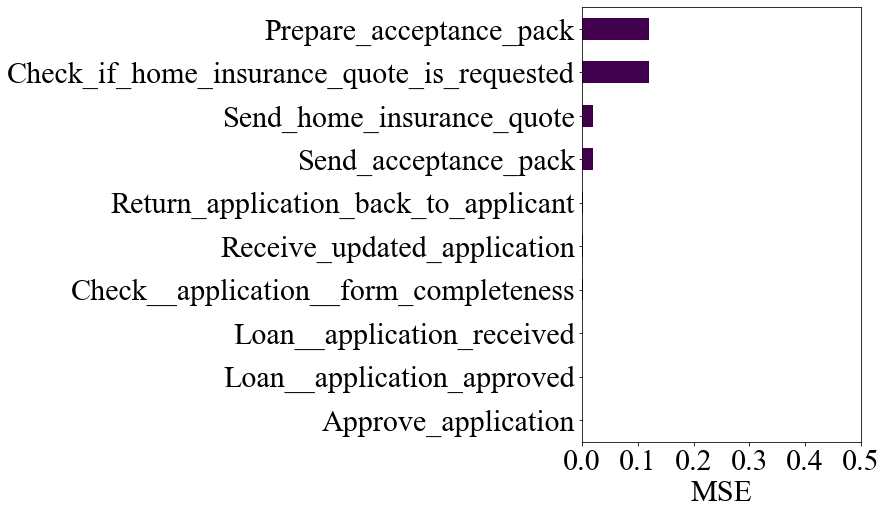

In [189]:
mses = df_plot.rename(columns=inv_aliases).loc[875].sort_values(ascending=True)
mses.tail(10).plot.barh(figsize=(5,8), colormap='PRGn')

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

ax.set_xlim((0, 0.5))
ax.set_xlabel('MSE')

Text(0.5, 0, 'MSE')

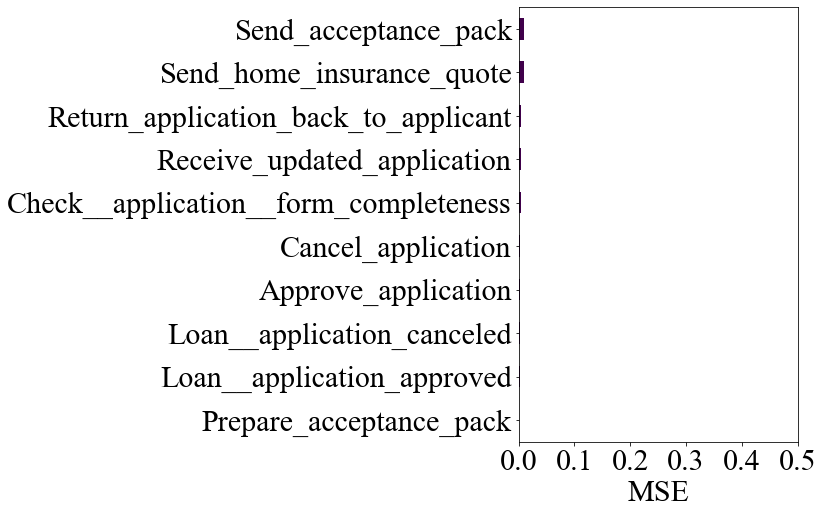

In [184]:
mses = df_plot.rename(columns=inv_aliases).loc[7125].sort_values(ascending=True)
mses.tail(10).plot.barh(figsize=(5,8), colormap="PRGn")

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

ax.set_xlim((0, 0.5))
ax.set_xlabel('MSE')

In [81]:
inv_aliases["A"]

'Appraise_property'

In [40]:
inv_aliases

{'START': 'Loan__application_received',
 'A': 'Appraise_property',
 'B': 'Approve_application',
 'C': 'Assess_eligibility',
 'D': 'Assess_loan_risk',
 'E': 'Cancel_application',
 'F': 'Check__application__form_completeness',
 'G': 'Check_credit_history',
 'H': 'Check_if_home_insurance_quote_is_requested',
 'I': 'Prepare_acceptance_pack',
 'J': 'Receive_updated_application',
 'K': 'Reject_application',
 'L': 'Return_application_back_to_applicant',
 'M': 'Send_acceptance_pack',
 'N': 'Send_home_insurance_quote',
 'O': 'Verify_repayment_agreement',
 'END_A': 'Loan__application_approved',
 'END_R': 'Loan_application_rejected',
 'END_C': 'Loan__application_canceled'}

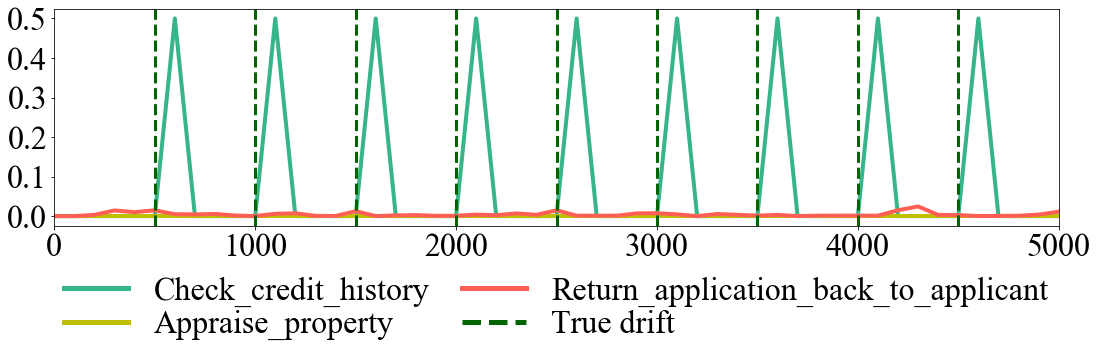

In [63]:
df_plot[["G", "A", "L"]].rename(columns=inv_aliases).plot(figsize=(18,4), lw=4, color = ['#35b588', 'y', '#ff5f54'])
plts.plot_drift_vertical_lines(c['log_size'], label="True drift")

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(32)

# ax.set_xlabel('índice dos $\it{traces}$')
ax.set_xlabel(None)
# ax.set_xlim((0, df.index.max() + 100))
# bbox_to_anchor=(0.5, 1.3),
leg = plt.legend(fontsize=32, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, prop={"family":"Times New Roman", "size":"32"},
          frameon=False, ncol=2, labelspacing=0.1, columnspacing=1)

for line in leg.get_lines():
    line.set_linewidth(5)

In [249]:
resp_df[
    (resp_df.tipo_mudanca == "cb") &
    (resp_df.representation == 'binary') &
    (resp_df.model == "kmeans__k=2") &
    (resp_df.window_size == 250) & 
    (resp_df.log_size == 5000)
]

,log_size,model,representation,sliding_window,tipo_mudanca,window_size,y_true,localizations,roc_scores,avg_precisions,AVG_roc_scores,AVG_avg_precisions,flag_binary_support,flag_frequency_support
1241,5000,kmeans__k=2,binary,False,cb,250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[{'H': 0.15849869354777202, 'I': 0.15849869354...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.0,1.0,True,True


### Versão com todas as janelas anteriores

In [285]:
resp__2 = pd.DataFrame.from_dict(resp__2)
resp__2

,log_size,model,representation,sliding_window,tipo_mudanca,window_size,y_true,localizations,roc_scores,avg_precisions,AVG_roc_scores,AVG_avg_precisions
0,10000,kmeans__k=2,transitions,False,cf,75,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.22222222444444445, 'M O': 0.0665006...","[0.7916666666666667, 0.875, 0.875, 0.75, 0.875...","[0.7794871794871795, 0.8678266178266179, 0.867...",0.787037,0.795094
1,10000,kmeans__k=2,transitions,False,cf,100,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.5, 'M O': 0.1408642408780667, 'N O'...","[0.75, 0.875, 0.875, 0.7083333333333334, 0.791...","[0.7589476495726496, 0.857905982905983, 0.8678...",0.777778,0.790776
2,10000,kmeans__k=2,transitions,False,cf,125,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.5, 'N O': 0.13857436956133617, 'M O...","[0.75, 0.75, 0.875, 0.7083333333333333, 0.7916...","[0.7589476495726496, 0.7606837606837606, 0.867...",0.763889,0.779486
3,10000,kmeans__k=2,transitions,False,cf,150,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.5, 'N O': 0.140847231039704, 'M O':...","[0.7083333333333333, 0.8333333333333333, 0.875...","[0.7446018893387314, 0.8113782051282051, 0.867...",0.768519,0.781490
4,10000,kmeans__k=2,transitions,False,cf,200,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[{'M N': 0.5, 'N O': 0.13391271574047678, 'M O...","[0.75, 0.7083333333333333, 0.875, 0.7083333333...","[0.7606837606837606, 0.7467948717948718, 0.857...",0.763889,0.778891
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,7500,kmeans__k=3,binary,False,lp,100,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...","[{'E': 0.12244897959183675, 'END_A': 0.1224489...","[0.3977272727272727, 0.3977272727272727, 0.397...","[0.4407894736842105, 0.4407894736842105, 0.440...",0.392677,0.436160
1292,7500,kmeans__k=3,binary,False,lp,125,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...","[{'N': 0.036978619968428945, 'M': 0.0369786199...","[0.3522727272727273, 0.3977272727272727, 0.397...","[0.3991228070175438, 0.4407894736842105, 0.440...",0.392677,0.436160
1293,7500,kmeans__k=3,binary,False,lp,150,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...","[{'E': 0.16666666666666666, 'END_A': 0.1666666...","[0.3977272727272727, 0.3977272727272727, 0.397...","[0.4407894736842105, 0.4407894736842105, 0.440...",0.397727,0.440789
1294,7500,kmeans__k=3,binary,False,lp,200,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...","[{'E': 0.07407407407407408, 'END_A': 0.0740740...","[0.3977272727272727, 0.3977272727272727, 0.318...","[0.4407894736842105, 0.4407894736842105, 0.421...",0.388889,0.438596


In [289]:
resp__2["flag_binary_support"] = resp__2["tipo_mudanca"].isin(binary_support + ['re'])
resp__2["flag_frequency_support"] = resp__2["tipo_mudanca"].isin(binary_support + ['re', 'lp'])

In [290]:
resp_df_grouped_2 = resp__2.groupby([
    'model', 'representation', 'sliding_window', 'tipo_mudanca', 'window_size',
]).agg({
    'AVG_roc_scores': 'mean',
    'AVG_avg_precisions': 'mean',
    'flag_binary_support': 'max',
    'flag_frequency_support': 'max',
}).reset_index()

resp_df_grouped_2.sort_values(["AVG_roc_scores", "window_size", 'representation', "model"],ascending=[False, True, True, True]).drop_duplicates("tipo_mudanca")

,model,representation,sliding_window,tipo_mudanca,window_size,AVG_roc_scores,AVG_avg_precisions,flag_binary_support,flag_frequency_support
0,kmeans__k=2,binary,False,cb,75,1.000000,1.000000,True,True
48,kmeans__k=2,binary,False,pm,75,1.000000,1.000000,True,True
54,kmeans__k=2,binary,False,re,75,1.000000,1.000000,True,True
60,kmeans__k=2,binary,False,rp,75,1.000000,1.000000,True,True
18,kmeans__k=2,binary,False,cm,75,0.990741,0.833333,True,True
211,kmeans__k=2,transitions,False,sw,100,0.939216,0.964583,False,False
229,kmeans__k=3,binary,False,cf,100,0.830688,0.696036,True,True
312,kmeans__k=3,frequency,False,cp,75,0.825132,0.723438,False,False
189,kmeans__k=2,transitions,False,pl,150,0.812203,0.882045,False,False
368,kmeans__k=3,transitions,False,cd,125,0.747318,0.761222,False,False


In [291]:
resp__2.to_excel("results_localization_experiments_TodaJanelaAnterior.xlsx")

In [292]:
resp__2.to_pickle("results_localization_experiments_TodaJanelaAnterior.pickle")

In [295]:
resp_df_grouped_2[resp_df_grouped_2.flag_frequency_support].groupby(['model', 'representation', 'sliding_window', 'window_size']).agg({
    'AVG_roc_scores': 'mean',
    'AVG_avg_precisions': 'mean',
}).reset_index().sort_values(["AVG_roc_scores", "AVG_avg_precisions"], ascending=False)

,model,representation,sliding_window,window_size,AVG_roc_scores,AVG_avg_precisions
26,kmeans__k=3,frequency,False,125,0.842959,0.811704
7,kmeans__k=2,frequency,False,100,0.840444,0.816752
8,kmeans__k=2,frequency,False,125,0.840178,0.812711
11,kmeans__k=2,frequency,False,250,0.838714,0.811968
10,kmeans__k=2,frequency,False,200,0.836858,0.807092
6,kmeans__k=2,frequency,False,75,0.836276,0.805166
25,kmeans__k=3,frequency,False,100,0.834754,0.764308
9,kmeans__k=2,frequency,False,150,0.833989,0.803653
27,kmeans__k=3,frequency,False,150,0.829467,0.766574
29,kmeans__k=3,frequency,False,250,0.828848,0.797713


In [298]:
resp_df_grouped_2[
    (resp_df_grouped_2.model == 'kmeans__k=3') &
    (resp_df_grouped_2.representation == "frequency") &
    (resp_df_grouped_2.window_size == 125)
]

,model,representation,sliding_window,tipo_mudanca,window_size,AVG_roc_scores,AVG_avg_precisions,flag_binary_support,flag_frequency_support
290,kmeans__k=3,frequency,False,cb,125,1.000000,1.000000,True,True
296,kmeans__k=3,frequency,False,cd,125,0.430515,0.403129,False,False
302,kmeans__k=3,frequency,False,cf,125,0.804233,0.689454,True,True
308,kmeans__k=3,frequency,False,cm,125,0.982510,0.820988,True,True
314,kmeans__k=3,frequency,False,cp,125,0.787831,0.696037,False,False
320,kmeans__k=3,frequency,False,fr,125,0.359568,0.375722,True,True
326,kmeans__k=3,frequency,False,lp,125,0.622054,0.718583,False,True
332,kmeans__k=3,frequency,False,pl,125,0.380071,0.394774,False,False
338,kmeans__k=3,frequency,False,pm,125,1.000000,1.000000,True,True
344,kmeans__k=3,frequency,False,re,125,0.975309,0.888889,True,True
